# Step 1.: Dealing the cards

In [35]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image, ImageDraw
import cv2
import numpy as np
from tqdm import tqdm

In [36]:
def deal_hand_and_flop(base_path, num_cards_probs=[0.35, 0.40, 0.15, 0.10]):
    """
    Select the hand and flop card images based on the given rules.
    - base_path: Base path for card images.
    - num_cards_probs: Probabilities for selecting the number of cards [2, 5, 6, 7].
    Returns:
        hand_cards (list): List of paths for the hand cards.
        flop_cards (list): List of paths for the flop cards.
    """
    # Define card classes and number of cards to draw
    classes = [ '2C', '2D', '2H', '2S',
                '3C', '3D', '3H', '3S',
                '4C', '4D', '4H', '4S',
                '5C', '5D', '5H', '5S', 
                '6C', '6D', '6H', '6S', 
                '7C', '7D', '7H', '7S', 
                '8C', '8D', '8H', '8S', 
                '9C', '9D', '9H', '9S',
                'TC', 'TD', 'TH', 'TS', 
                'AC', 'AD', 'AH', 'AS', 
                'JC', 'JD', 'JH', 'JS',
                'KC', 'KD', 'KH', 'KS', 
                'QC', 'QD', 'QH', 'QS']
    num_cards_options = [2, 5, 6, 7]

    # Step 1: Randomly choose a deck
    deck = random.choice(["first", "second"])
    suffix = "_" if deck == "second" else ""

    #Constructing the bounding box for the yolo format (x_center, y_center, width, height)
    if deck == "first":
        b_boxes_yolo = [[66, 145, 100, 230], [625, 911, 100, 230], [345, 528, 691, 1056]]
        #b_boxes_yolo = [66, 145, 100, 230]
    else:
        b_boxes_yolo = [[45, 90, 90, 180], [455, 636, 90, 180], [250, 363, 500, 726]]
        #b_boxes_yolo = [45, 90, 90, 180]
    

    # Step 2: Shuffle and draw a random number of cards
    random.shuffle(classes)
    num_cards = random.choices(num_cards_options, weights=num_cards_probs, k=1)[0]
    selected_classes = classes[:num_cards]

    hand_labels = [[card, b_boxes_yolo] for card in selected_classes[:2]]
    flop_labels = [[card, b_boxes_yolo] for card in selected_classes[2:]]

    # Step 3: Generate file paths for the selected cards
    hand_paths = [os.path.join(base_path, f"{suffix}{card}.png") for card in selected_classes[:2]]
    flop_paths = [os.path.join(base_path, f"{suffix}{card}.png") for card in selected_classes[2:]]

    return hand_paths, flop_paths, hand_labels, flop_labels

In [37]:
def yolo_notation2cv2_notation(yolo_notation):
    x, y, w, h = yolo_notation
    #Upper left
    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    #Upper right
    x2 = x1 + w
    y2 = y1
    #Lower right
    x3 = x2
    y3 = y1 + h
    #Lower left
    x4 = x1
    y4 = y3

    return np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

def cv2_notation2yolo_notation(cv2_notation):
    x1, y1 = cv2_notation[0]
    x3, y3 = cv2_notation[2]
    
    #Width and height
    w = x3 - x1
    h = y3 - y1

    #Center
    x = x1 + w / 2
    y = y1 + h / 2
    
    return x, y, w, h

def cv2_modified2yolo_notation(cv2_modified):
    # Extract the x and y coordinates from the points
    x_coords = cv2_modified[:, 0]
    y_coords = cv2_modified[:, 1]

    # Calculate the center
    x_center = sum(x_coords) / 4
    y_center = sum(y_coords) / 4

    # Calculate the width and height
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)

    return x_center, y_center, width, height

Here is an example of what the first function does

Hand cards:  [['6S', [[66, 145, 100, 230], [625, 911, 100, 230], [345, 528, 691, 1056]]], ['9C', [[66, 145, 100, 230], [625, 911, 100, 230], [345, 528, 691, 1056]]]]


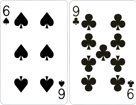

Flop cards:  [['4C', [[66, 145, 100, 230], [625, 911, 100, 230], [345, 528, 691, 1056]]], ['6H', [[66, 145, 100, 230], [625, 911, 100, 230], [345, 528, 691, 1056]]], ['7S', [[66, 145, 100, 230], [625, 911, 100, 230], [345, 528, 691, 1056]]]]


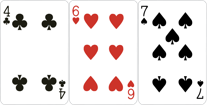

In [38]:
from IPython.display import display

benchmarks_path = "../shared_data/benchmark"
hand_paths, flop_paths, hand_labels, flop_labels = deal_hand_and_flop(benchmarks_path)

# Convert cv2 images to PIL images
hand = [Image.open(path).convert("RGBA") for path in hand_paths]
flop = [Image.open(path).convert("RGBA") for path in flop_paths]
hand = [card.resize((int(card.width * 0.1), int(card.height * 0.1))) for card in hand]
flop = [card.resize((int(card.width * 0.1), int(card.height * 0.1))) for card in flop]

# Display hand cards next to each other
hand_combined = Image.new("RGBA", (hand[0].width * len(hand), hand[0].height))
for i, card in enumerate(hand):
    hand_combined.paste(card, (i * card.width, 0))
print("Hand cards: ", hand_labels)
display(hand_combined)

# Display flop cards next to each other
if flop:
    flop_combined = Image.new("RGBA", (flop[0].width * len(flop), flop[0].height))
    for i, card in enumerate(flop):
        flop_combined.paste(card, (i * card.width, 0))
    print("Flop cards: ", flop_labels)
    display(flop_combined)
else:
    print("Flop cards: None")

## Step 1.1: Auxiliary functions

### Independent rotation of the single images

In [39]:
def rotate_image(image, b_boxes_yolo, angle):
    """
    Rotate the image around its center.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x 3).
    - b_box_yolo: Bounding box in YOLO format (x_center, y_center, width, height).
    - angle: Angle in degrees.
    
    Returns:
    - rotated_image: The rotated image.
    - rotated_bb_yolo: The rotated bounding box in YOLO format.
    """

    h, w = image.shape[:2]
    new_w = int(w * abs(np.cos(np.deg2rad(angle))) + h * abs(np.sin(np.deg2rad(angle))))
    new_h = int(h * abs(np.cos(np.deg2rad(angle))) + w * abs(np.sin(np.deg2rad(angle))))
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2

    # Rotate the bounding box
    def rotate_bounding_box(b_box_yolo):
        bb_coords = yolo_notation2cv2_notation(b_box_yolo)
        bb_coords = np.hstack([bb_coords, np.ones((bb_coords.shape[0], 1), dtype=bb_coords.dtype)])
        rotated_points = bb_coords @ M.T
        return cv2_modified2yolo_notation(rotated_points)
    
    b_boxes_yolo = [rotate_bounding_box(b_box_yolo) for b_box_yolo in b_boxes_yolo]    

    rotated_image = cv2.warpAffine(image, M, (new_w, new_h))
    return rotated_image, b_boxes_yolo

### Translation of the images one next to the other

Deal with the hand case first and the flop then

In [40]:
def generate_canvas(cards, overlap_factor, max_w):
    canvas_h = max([card.shape[0] for card in cards])
    canvas_w = sum([card.shape[1] for card in cards]) - int(max_w * overlap_factor) 
    canvas = np.ones((canvas_h, canvas_w, 4), dtype=np.uint8) * 255
    canvas[..., 3] = 0
    return canvas


def dynamic_canvas_adjustment(canvas, cards, overlap_factor, positions, max_w):
    for i in range(1, len(cards)):
        last_x, last_y = positions[-1]
        overlap_x = cards[i - 1].shape[1] - int(overlap_factor * max_w)
        positions.append((last_x + overlap_x, last_y))

    canvas_h, canvas_w = canvas.shape[:2]
    min_x = min([pos[0] for pos in positions])
    if min_x < 0:
        # Expand the canvas width by abs(min_x) on the left
        new_canvas_w = canvas_w + abs(min_x)
        new_canvas = np.ones((canvas_h, new_canvas_w, 4), dtype=np.uint8) * 255

        # Shift all positions to the right by abs(min_x)
        positions = [(pos[0] + abs(min_x), pos[1]) for pos in positions]

        # Copy old canvas into the new one
        new_canvas[:, abs(min_x):, :] = canvas
        canvas = new_canvas
    
    return canvas, positions


def expand_canvas(canvas, h, w, x, y):
    if x + w > canvas.shape[1]:
        # Expand the canvas width
        new_canvas_w = x + w
        new_canvas = np.ones((canvas.shape[0], new_canvas_w, 4), dtype=np.uint8) * 255
        new_canvas[:, :canvas.shape[1], :] = canvas
        canvas = new_canvas
    if y + h > canvas.shape[0]:
        # Expand the canvas height
        new_canvas_h = y + h
        new_canvas = np.ones((new_canvas_h, canvas.shape[1], 4), dtype=np.uint8) * 255
        new_canvas[:canvas.shape[0], :, :] = canvas
        canvas = new_canvas
    return canvas

In [41]:
def overlay_random_transparent_object(base_image: np.ndarray, object_folder: str) -> np.ndarray:
    """
    Overlays a randomly selected transparent image from `object_folder` onto `base_image`.
    Scales the object (hand) so that its height is 110% of the base image's height,
    then places it randomly in the lower 60% of the base image, allowing partial cropping.
    
    Parameters:
        base_image (np.ndarray): The base RGBA image (H x W x 4).
        object_folder (str): Path to the folder containing transparent RGBA images.
    
    Returns:
        np.ndarray: The modified RGBA image after overlay.
    """
    
    # Get a list of all files in the object folder
    object_files = [f for f in os.listdir(object_folder) if not f.startswith('.') and os.path.isfile(os.path.join(object_folder, f))]
    if not object_files:
        raise ValueError("No object files found in the given folder.")
    
    # Randomly select an object image file
    obj_file = random.choice(object_files)
    obj_path = os.path.join(object_folder, obj_file)
    
    # Load the object image with alpha channel
    obj_img = cv2.cvtColor(cv2.imread(obj_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA) 

    # Randomly mirror the object image with 50% probability
    if random.random() < 0.5:
        obj_img = cv2.flip(obj_img, 1)  # Flip horizontally

    # Get dimensions of base and object
    base_h, base_w = base_image.shape[:2]
    obj_h, obj_w = obj_img.shape[:2]
    
    # Scale the object so that its height is 110% of the base image height
    desired_obj_h = int(1.1 * base_h)
    scale_factor = desired_obj_h / obj_h
    desired_obj_w = int(obj_w * scale_factor)
    obj_img = cv2.resize(obj_img, (desired_obj_w, desired_obj_h), interpolation=cv2.INTER_AREA)
    obj_h, obj_w = obj_img.shape[:2]

    # We want to place the object in the lower 60% of the card
    # That means y should be from 0.4 * base_h to base_h
    y_min = int(0.2 * base_h)
    y_max = base_h  # potentially placing it so that part goes below the card
    
    top_left_y = random.randint(y_min, y_max)
    
    # For x, we can allow some part to fall out of the image as well.
    # Let's choose x from a range that might allow partial clipping on either side.
    # For example, from -obj_w//2 to base_w (allow half the width to go off-screen on the left)
    x_min = -obj_w // 2
    x_max = base_w
    top_left_x = random.randint(x_min, x_max)

    # Compute the overlapping area between the object and the base image
    # Visible region in the base image
    visible_x_start = max(0, top_left_x)
    visible_y_start = max(0, top_left_y)
    visible_x_end = min(base_w, top_left_x + obj_w)
    visible_y_end = min(base_h, top_left_y + obj_h)

    # If there's no overlap, just return the base image as is
    if visible_x_end <= visible_x_start or visible_y_end <= visible_y_start:
        return base_image

    # Corresponding region in the object
    obj_x_start = visible_x_start - top_left_x
    obj_y_start = visible_y_start - top_left_y
    obj_x_end = obj_x_start + (visible_x_end - visible_x_start)
    obj_y_end = obj_y_start + (visible_y_end - visible_y_start)

    # Extract the relevant portion of the object and the alpha channel
    obj_crop = obj_img[obj_y_start:obj_y_end, obj_x_start:obj_x_end, :]
    alpha_obj = obj_crop[:, :, 3] / 255.0

    # Extract the corresponding base area
    base_crop = base_image[visible_y_start:visible_y_end, visible_x_start:visible_x_end, :]
    alpha_base = base_crop[:, :, 3] / 255.0

    # Compute the combined alpha
    combined_alpha = alpha_obj + alpha_base * (1 - alpha_obj)

    # For each color channel: R, G, B
    for c in range(3):
        base_crop[:, :, c] = (
            obj_crop[:, :, c] * alpha_obj +
            base_crop[:, :, c] * alpha_base * (1 - alpha_obj)
        ) / np.maximum(combined_alpha, 1e-6)

    # Update the alpha channel
    base_crop[:, :, 3] = (combined_alpha * 255).astype(np.uint8)

    # Put the blended region back into the base image
    base_image[visible_y_start:visible_y_end, visible_x_start:visible_x_end, :] = base_crop

    return base_image

In [42]:
def transform_merge(card_paths, card_labels, object_folder):
    # Extract the cards
    cards = [cv2.cvtColor(cv2.imread(card), cv2.COLOR_BGR2RGBA) for card in card_paths]
    # Genearate the angles for rotation and percentage of overlap
    if len(cards) == 2:
        angles = [np.random.normal(0, 20) for _ in range(len(cards))]
        overlap_factor = np.clip(np.random.normal(0.4, 0.2), -0.1, .7)
    else:
        angles = [np.random.normal(0, 5) for _ in range(len(cards))]
        overlap_factor = np.clip(np.random.normal(0, 0.2), -0.2, 0.2)

    # Apply shading and Gaussian blur
    shading_coeff = np.clip(np.random.normal(1, 0.3), 0.3, 2)
    for i in range(len(cards)):
        cards[i][..., :3] = np.clip(cards[i][..., :3] * shading_coeff, 0, 255).astype(np.uint8)
        cards[i] = cv2.GaussianBlur(cards[i], (5, 5), 0)

    # Rotate the cards
    rotated_cards = []
    modified_labels = []
    for card, label, angle in zip(cards, card_labels, angles):
        rotated_card, rotated_bboxes = rotate_image(card, label[1], angle)
        rotated_cards.append(rotated_card)
        modified_labels.append([label[0], rotated_bboxes])

    # Define the canvas to fit the cards
    max_w = max([rotated_card.shape[1] for rotated_card in rotated_cards])
    canvas = generate_canvas(rotated_cards, overlap_factor, max_w)

    positions = [(0, 0)]
    canvas, positions = dynamic_canvas_adjustment(canvas, rotated_cards, overlap_factor, positions, max_w)
    for j in range(1, len(positions)):
        for i in range(len(modified_labels[j][1])):
            modified_labels[j][1][i] = list(modified_labels[j][1][i])
            modified_labels[j][1][i][0] += positions[j][0]
            modified_labels[j][1][i] = tuple(modified_labels[j][1][i])

    # Randomly reverse the order of the cards
    if np.random.rand() > 0.5: 
        rotated_cards = reversed(rotated_cards)
        positions = list(reversed(positions))

    
    # Merge the cards onto the canvas
    for card, pos in zip(rotated_cards, positions):
        card_h, card_w = card.shape[:2]
        x, y = pos

        # Check if the card exceeds the canvas boundaries and adjust
        canvas = expand_canvas(canvas, card_h, card_w, x, y)

        alpha = card[:, :, 3] / 255.0
        for c in range(3):
            canvas[y:y+card_h, x:x+card_w, c] = (
                card[:, :, c] * alpha +
                canvas[y:y+card_h, x:x+card_w, c] * (1.0 - alpha)
            )
        # Update alpha channel
        canvas[y:y+card_h, x:x+card_w, 3] = (
            alpha * 255 + canvas[y:y+card_h, x:x+card_w, 3] * (1.0 - alpha)
        )

    canvas_h, canvas_w = canvas.shape[:2]
    if len(cards) == 2:
        if random.random() > 0.5:
            # Cut the cards with a random factor
            cut_factor = np.clip(np.random.normal(4, 3), 3, None)
            canvas_h = canvas.shape[0]
            canvas = canvas[:-int(canvas_h/cut_factor)]
        if random.random() > 0.5:
            canvas = overlay_random_transparent_object(canvas, object_folder)
        modified_labels.append(['hand', [[canvas_w//2, canvas_h//2, canvas_w, canvas_h]]])
    else:
        modified_labels.append(['flop', [[canvas_w//2, canvas_h//2, canvas_w, canvas_h]]])

    

    return canvas, modified_labels

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

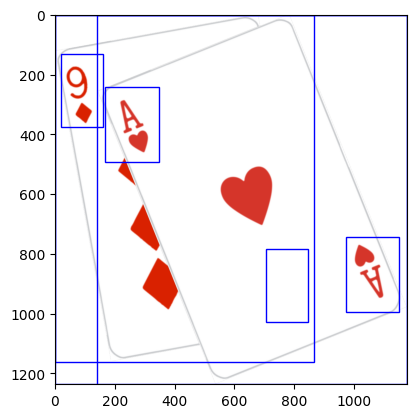

In [44]:
hand, _, hand_labels, _ = deal_hand_and_flop(benchmarks_path)
merged_hand, modified_bboxes = transform_merge(hand, hand_labels,  '../shared_data/objects')
fig, ax = plt.subplots()
for c in modified_bboxes:
    for bbox in c[1]:
        upper_left = tuple(yolo_notation2cv2_notation(bbox)[0])
        rect = Rectangle(upper_left, bbox[2], bbox[3], linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
ax.imshow(merged_hand)
plt.show()

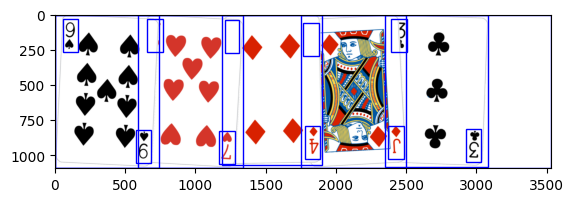

In [45]:
_, flop, _, label_flop = deal_hand_and_flop(benchmarks_path)
merged_flop, flop_labels = transform_merge(flop, label_flop, '../shared_data/objects')
fig, ax = plt.subplots()
for c in flop_labels:
    for bbox in c[1]:
        upper_left = tuple(yolo_notation2cv2_notation(bbox)[0])
        rect = Rectangle(upper_left, bbox[2], bbox[3], linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
plt.imshow(merged_flop)
plt.show()

### Apply some shading and lighting to the images and objects ostacles on the hands

### Final warping function

In [46]:
def rotate_image_3d_centered(image, image_labels, pitch, yaw, f=2000):
    """
    Rotate the image in 3D around its center and keep the center of the image stable.
    The output canvas is adjusted so the entire rotated image is visible.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x 3).
    - pitch: Pitch angle in degrees (rotation around x-axis).
    - yaw:   Yaw angle in degrees (rotation around y-axis).
    - f:     Focal length for the projection (in pixels).

    Returns:
    - warped_image: The rotated image, with the center in roughly the same position 
                    and no cutoff.
    """
    h, w = image.shape[:2]

    # Image center
    cx, cy = w / 2.0, h / 2.0

    # Convert angles to radians
    pitch_rad = np.deg2rad(pitch)
    yaw_rad = np.deg2rad(yaw)

    # Rotation matrices
    R_pitch = np.array([
        [1,              0,               0           ],
        [0,  np.cos(pitch_rad), -np.sin(pitch_rad)],
        [0,  np.sin(pitch_rad),  np.cos(pitch_rad)]
    ], dtype=np.float32)

    R_yaw = np.array([
        [ np.cos(yaw_rad), 0, np.sin(yaw_rad)],
        [ 0,               1,              0],
        [-np.sin(yaw_rad), 0, np.cos(yaw_rad)]
    ], dtype=np.float32)

    # Combined rotation
    R = R_yaw @ R_pitch

    # Original corners
    original_corners_2d = np.array([[0,0],
                                    [w,0],
                                    [w,h],
                                    [0,h]], dtype=np.float32)

    corners_3d = np.array([
        [0, 0, 0],
        [w, 0, 0],
        [w, h, 0],
        [0, h, 0]
    ], dtype=np.float32)

    # Center the corners around the image center
    corners_centered = corners_3d - [cx, cy, 0]

    # Rotate corners
    rotated_corners = corners_centered @ R.T

    # Project corners
    Z = rotated_corners[:, 2] + f
    X = rotated_corners[:, 0]
    Y = rotated_corners[:, 1]

    Z[Z == 0] = 0.001
    projected_corners = np.zeros((4, 2), dtype=np.float32)
    projected_corners[:, 0] = (f * X / Z) + cx
    projected_corners[:, 1] = (f * Y / Z) + cy

    # Project the original center to see where it lands
    center_3d = np.array([[cx, cy, 0]], dtype=np.float32)
    center_centered = center_3d - [cx, cy, 0]
    center_rotated = center_centered @ R.T
    Zc = center_rotated[0, 2] + f
    Xc = center_rotated[0, 0]
    Yc = center_rotated[0, 1]
    proj_cx = (f * Xc / Zc) + cx
    proj_cy = (f * Yc / Zc) + cy

    # Compute homography
    H, _ = cv2.findHomography(original_corners_2d, projected_corners)

    # We want the projected center to remain at (cx, cy)
    # So we translate by (cx - proj_cx, cy - proj_cy)
    T_center = np.array([
        [1, 0, cx - proj_cx],
        [0, 1, cy - proj_cy],
        [0, 0, 1]
    ], dtype=np.float32)

    H_adjusted = T_center @ H

    # Apply H_adjusted to corners to find the final bounding box
    ones = np.ones((4,1), dtype=np.float32)
    corners_h = np.hstack([original_corners_2d, ones])
    transformed_corners = (H_adjusted @ corners_h.T).T
    transformed_corners = transformed_corners[:, :2] / transformed_corners[:, 2:3]

    # Compute bounding box
    all_x = transformed_corners[:, 0]
    all_y = transformed_corners[:, 1]
    min_x, max_x = np.min(all_x), np.max(all_x)
    min_y, max_y = np.min(all_y), np.max(all_y)

    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))

    # We also need to shift so that the bounding box starts at (0,0)
    # We'll add another translation to the homography
    T_box = np.array([
        [1, 0, -min_x],
        [0, 1, -min_y],
        [0, 0, 1]
    ], dtype=np.float32)

    H_final = T_box @ H_adjusted

    # Warp with final homography
    warped_image = cv2.warpPerspective(image, H_final, (new_w, new_h))

    # Warp the bounding box
    def warp_bounding_box(b_box_yolo):
        points = yolo_notation2cv2_notation(b_box_yolo)
        points_h = np.hstack([points, np.ones((points.shape[0], 1), dtype=points.dtype)])
        transformed_points_h = (H_final @ points_h.T).T

        transformed_points = transformed_points_h[:, :2] / transformed_points_h[:, 2:3]
        return cv2_modified2yolo_notation(transformed_points)

    for i, c in enumerate(image_labels):
        image_labels[i] = [c[0], [warp_bounding_box(b_box_yolo) for b_box_yolo in c[1]]]

    return warped_image, image_labels

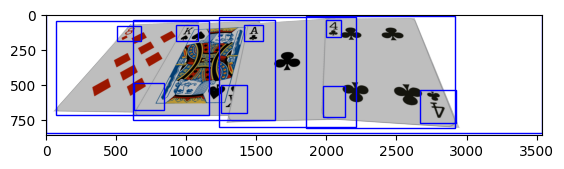

In [48]:
_, flop, _, label_flop = deal_hand_and_flop(benchmarks_path)
merged_flop, flop_labels = transform_merge(flop, label_flop, '../shared_data/objects')
warped_flop, warped_labels = rotate_image_3d_centered(merged_flop, flop_labels, -50, 10)
fig, ax = plt.subplots()
for c in warped_labels:
    for bbox in c[1]:
        upper_left = tuple(yolo_notation2cv2_notation(bbox)[0])
        rect = Rectangle(upper_left, bbox[2], bbox[3], linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
plt.imshow(warped_flop)
plt.show()

# Step 2.: Add the modified Hand Cards to the background images

In [49]:
def scale_bounding_boxes(labels, scale_x, scale_y):
    for item in labels:
        item[1] = [(x * scale_x, y * scale_y, w * scale_x, h * scale_y) for x, y, w, h in item[1]]
    
    return labels

def translate_coordinates(labels, shift_x, shift_y):
    for item in labels:
        item[1] = [ (x + shift_x, y + shift_y, w, h) for x, y, w, h in item[1]]
    
    return labels

In [50]:
warped_labels

[['8D',
  [(592.5398714856658,
    128.55102734824817,
    168.77071963458536,
    105.8820887385337),
   (737.4642795890511,
    579.1326616303168,
    217.1926729820624,
    186.9492650998697),
   (620.0222623594309,
    377.182398947489,
    1092.0481638970311,
    667.6098867423982)]],
 ['KS',
  [(1007.8632964496832,
    127.20266133755788,
    153.92119759774187,
    111.59229715167194),
   (1342.9113341365717,
    594.9429536186624,
    181.85333718956053,
    201.42078714844422),
   (1128.9085819490688,
    389.68533966160135,
    1010.0005854889914,
    717.8992991501424)]],
 ['AC',
  [(1481.1092676516785,
    126.9696413775397,
    134.84517225955142,
    118.41857492916681),
   (2056.447706632467,
    612.8337346164967,
    157.69589934107353,
    218.83651587222852),
   (1725.662607087876,
    406.104732630685,
    976.4305541745205,
    780.2539964554775)]],
 ['4C',
  [(2050.003170265228,
    94.78526495544975,
    109.12417878906808,
    118.67152567086899),
   (2796.79715

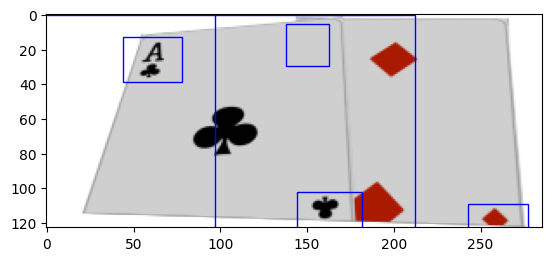

In [51]:
hand, _, hand_label, _ = deal_hand_and_flop(benchmarks_path)
merged_hand, merged_labels = transform_merge(hand, hand_label, '../shared_data/objects')
warped_hand, warped_labels = rotate_image_3d_centered(merged_hand, merged_labels, -50, 10)
h_hand_new = warped_hand.shape[0]//5
w_hand_new = warped_hand.shape[1]//5
resized_hand = cv2.resize(warped_hand,(w_hand_new, h_hand_new), interpolation=cv2.INTER_AREA)
scaled_labels = scale_bounding_boxes(warped_labels,1/5, 1/5)
fig, ax = plt.subplots()
for c in scaled_labels:
    for bbox in c[1]:
        upper_left = tuple(yolo_notation2cv2_notation(bbox)[0])
        rect = Rectangle(upper_left, bbox[2], bbox[3], linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
plt.imshow(resized_hand)
plt.show()

In [52]:
def display_pic(image, labels):
    fig, ax = plt.subplots()
    for c in labels:
        for bbox in c[1]:
            upper_left = tuple(yolo_notation2cv2_notation(bbox)[0])
            rect = Rectangle(upper_left, bbox[2], bbox[3], linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
    plt.imshow(image)
    plt.show()

In [53]:
def merge_cards_background(cards_folder, background_path, objects_folder):

    background = cv2.cvtColor(cv2.imread(background_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
    hand, flop, hand_labels, flop_labels = deal_hand_and_flop(cards_folder)

    hand, trans_hand_labels = transform_merge(hand, hand_labels, objects_folder)
    pitch_hand = np.random.normal(50, 10)
    yaw_hand = np.random.randint(-45, 45)

    hand, final_hand_labels = rotate_image_3d_centered(hand, trans_hand_labels, pitch=pitch_hand, yaw=yaw_hand, f=2500)

    # Display the hand cards
    display_pic(hand, final_hand_labels)

    h_hand_new = int(np.round(hand.shape[0] /5))
    w_hand_new = int(np.round(hand.shape[1] /5))
    resized_hand = cv2.resize(hand,(w_hand_new, h_hand_new), interpolation=cv2.INTER_AREA)
    x_new = int((yaw_hand+45)/90 * (background.shape[1]-w_hand_new)) 
    y_new = np.random.randint(background.shape[0]//2, background.shape[0]-h_hand_new)

    resized_hand_labels = scale_bounding_boxes(final_hand_labels, 1/5, 1/5)
    display_pic(resized_hand, resized_hand_labels)
    shifted_hand_labels = translate_coordinates(resized_hand_labels, x_new, y_new)
    

    alpha = resized_hand[:, :, 3] / 255.0
    for c in range(3):
        background[y_new:y_new+h_hand_new, x_new:x_new+w_hand_new, c] = (
            resized_hand[:, :, c] * alpha +
            background[y_new:y_new+h_hand_new, x_new:x_new+w_hand_new, c] * (1.0 - alpha)
        )
    display_pic(background, shifted_hand_labels)

    if len(flop) > 0:
        flop, trans_flop_labels = transform_merge(flop, flop_labels, objects_folder)
        yaw_flop = np.random.normal(0, 3)
        pitch_flop = np.random.randint(-75, -50)

        flop, final_flop_labels = rotate_image_3d_centered(flop, trans_flop_labels, pitch=pitch_flop, yaw=yaw_flop, f=2500)

        h_new_flop = int(np.round(flop.shape[0] / 8))
        w_new_flop = int(np.round(flop.shape[1] / 8))
        if background.shape[1] - w_new_flop <= 0:
            w_new_flop = int(np.round(flop.shape[1] // 10))
        resized_flop = cv2.resize(flop, (w_new_flop, h_new_flop), interpolation=cv2.INTER_AREA)

        x_new_flop = np.random.randint(0, background.shape[1]-w_new_flop)

        # Calculate y_new based on pitch_flop
        min_y_flop = 0
        max_y_flop = background.shape[0] // 2 - h_new_flop
        pitch_normalized_flop = (-pitch_flop - 50) / 30  # Normalize pitch to [0, 1] for range [-80, -50]
        y_new_flop = int(min_y_flop + pitch_normalized_flop * (max_y_flop - min_y_flop))

        resized_flop_labels = scale_bounding_boxes(final_flop_labels, 1/8, 1/8)
        shifted_flop_labels = translate_coordinates(resized_flop_labels, x_new_flop, y_new_flop)

        # Alpha blending for flop
        alpha_flop = resized_flop[:, :, 3] / 255.0
        for c in range(3):
            background[y_new_flop:y_new_flop+h_new_flop, x_new_flop:x_new_flop+w_new_flop, c] = (
                resized_flop[:, :, c] * alpha_flop +
                background[y_new_flop:y_new_flop+h_new_flop, x_new_flop:x_new_flop+w_new_flop, c] * (1.0 - alpha_flop)
            )
    shifted_flop_labels = 0
    return background, shifted_hand_labels, shifted_flop_labels

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_bounding_boxes(image, labels):
    """
    Plots bounding boxes on the image for visual inspection.
    
    Args:
    - image: The image as a NumPy array (H, W, C).
    - labels: The bounding box labels in the format:
              [['class1', [(x1, y1, w1, h1), ...]], ['class2', [(x2, y2, w2, h2), ...]], ...].
    """
    # Make a copy of the image to avoid modifying the original
    img_copy = image.copy()

    # Iterate over the bounding box labels
    for item in labels:
        class_name, boxes = item
        for (x, y, w, h) in boxes:
            # Convert coordinates to integers
            x, y, w, h = int(x), int(y), int(w), int(h)
            
            # Draw a rectangle for the bounding box
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)
            
            # Add the class label as text
            cv2.putText(
                img_copy, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5, color=(255, 255, 255), thickness=1, lineType=cv2.LINE_AA
            )
    # Plot the image with bounding boxes
    plt.figure(figsize=(12, 8))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

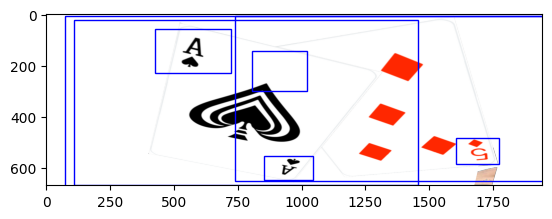

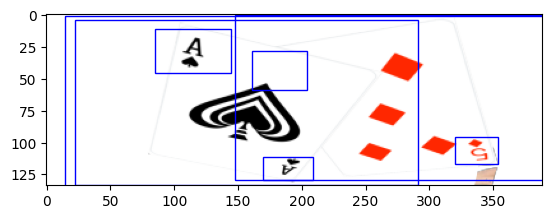

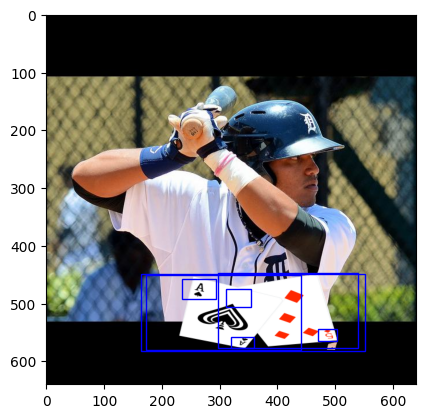

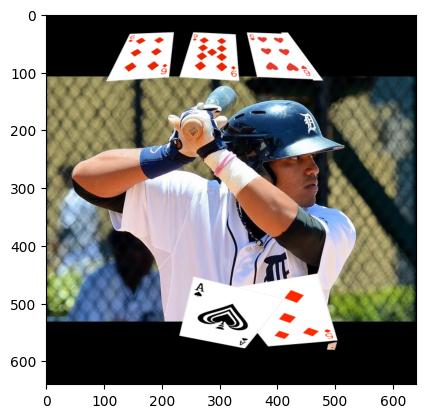

In [55]:
background, hand_labels, flop_labels = merge_cards_background(benchmarks_path, '../background/image_0.jpg', '../shared_data/objects')
plt.imshow(background)

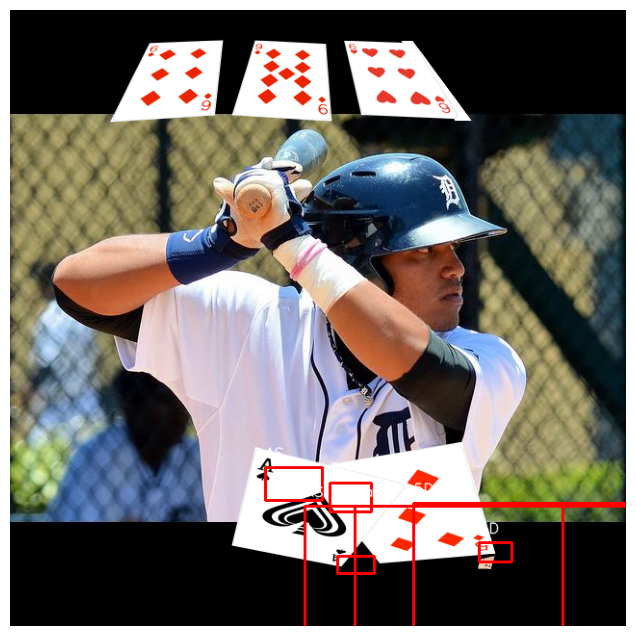

In [56]:
plot_bounding_boxes(background, hand_labels)